In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

## Проверка гипотезы о различии среднего времени активности пользователей по городам


### Цели и задачи проекта

`Цель`: проверить статистическую гипотезу о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении Яндекс.Книги, чем пользователи из Москвы.

`Задачи`: загрузить и проверить данные, рассчитать параметры А/В-теста, оценить корректность его проведения и проанализировать результаты.

### Описание данных


Таблица содержит данные о чтении и прослушивании контента в сервисе Яндекс Книги. 

Данные представлены за период с 1 сентября по 11 декабря 2024 года для Москвы и Санкт-Петербурга. 

Таблица `yandex_knigi_data.csv` содержит данные об активности пользователей и состоит из следующих полей:
 - city — город пользователя;
 - puid — идентификатор пользователя;
 - hours — общее количество часов активности.

### Содержимое проекта

 - [Загрузка данных и знакомство с ними](#1-loading-data)

 - [Проверка гипотезы](#2-check)

 - [Аналитическая записка](#3-summary)

<a class = "anchor" id = "1-loading-data" ><a/>
### Загрузка данных и знакомство с ними

Загрузим данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [2]:
# Выгружаем данные 
yandex_knigi = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

In [3]:
# Выводим первые строки датафрейма на экран
yandex_knigi.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [4]:
# Выводим информацию о датафрейме
yandex_knigi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


 - Датасет `yandex_knigi` содержит 4 столбца и 8784 строк, в которых представлены данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности в период с 01.09.2024 по 11.12.2024.
 - Типы данных в целом заданы верно, но можно провести оптимизацию: city для экономии памяти и упрощения группировок можно перевести в тип category, а столбец без названия, который не несет полезной функции, можно удалить.
 - Названия столбцов корректны, соответствуют тематики и приведены к единому формату snake_case.
 - Пропусков в данных нет. Все 4 столбца полностью заполнены.

 - Убедимся, что данные содержат только пользователей из Москвы и Санкт-Петербурга.

In [5]:
# Проверим уникальные значения в столбцe `city`
display(sorted(yandex_knigi['city'].unique()))

['Москва', 'Санкт-Петербург']

 - Выполним проверку на наличие полных дубликатов записей.

In [6]:
# Проверяем полные дубликаты в yandex_knigi
print(f"Полных дубликатов в датафрейме yandex_knigi: {yandex_knigi.duplicated().sum()}")

Полных дубликатов в датафрейме yandex_knigi: 0


В датафрейме нет полных дубликатов строк. 

 - Проверим неявные дубликаты — значения по puid клиентов должны быть уникальными. Это важно, чтобы убедиться, что каждый пользователь представлен в таблице уникально (находился исключительно в одной из групп) и результаты анализа не искажены повторяющимися записями.

In [7]:
# Найдем неявные дубликаты в столбце puid с помощью метода duplicated() 
duplicates_user = yandex_knigi.duplicated(subset='puid', keep=False)

# Подсчитаем количество и долю дубликатов
duplicates_count = duplicates_user.sum()
duplicates_percent = duplicates_count / len(yandex_knigi) * 100

# Выведем результаты
print(f"Неявных дубликатов (по столбцу puid): {duplicates_count}")
print(f"Доля дубликатов от всех строк: {duplicates_percent:.2f}%")

Неявных дубликатов (по столбцу puid): 488
Доля дубликатов от всех строк: 5.56%


488 пользователей одновременно присутствуют в двух группах. Для предотвращения искажения результатов их следует исключить из анализа.

In [8]:
# Удалим все строки, где puid встречается более одного раза
yandex_knigi_no_dupes = yandex_knigi[~duplicates_user].copy()

# Проверим результат
print(f"После удаления всех дубликатов осталось строк: {len(yandex_knigi_no_dupes)}")
print(f"Разница строк: {len(yandex_knigi) - len(yandex_knigi_no_dupes)}")

После удаления всех дубликатов осталось строк: 8296
Разница строк: 488


На данном этапе были выполнены следующие действия:

 - Импортированы данные из файла yandex_knigi_data.csv.
 - Проверена корректность типов данных и наличие пропусков.
 - Подтверждено, что в наборе данных присутствуют только пользователи из Москвы и Санкт-Петербурга.
 - Проведена проверка на наличие полных дубликатов и повторов по идентификаторам пользователей.
 - Исключены 488 записей пользователей, попавших одновременно в контрольную и тестовую группы.

<a class = "anchor" id = "2-check" ><a/>
### Проверка гипотезы в Python


 - Сравним размеры выборок по городам. 

Для этого рассчитаем количество уникальных пользователей в каждой из групп и на основе этих данных построим столбчатую диаграмму.

In [9]:
# Подсчёт количества уникальных пользователей по каждому городу
unique_users_per_city = yandex_knigi_no_dupes.groupby('city')['puid'].nunique().reset_index().rename(columns={'puid': 'unique_users'})

In [10]:
# Вывод на экран
print("Количество уникальных пользователей в каждой группе(городе):")
display(unique_users_per_city)

Количество уникальных пользователей в каждой группе(городе):


,city,unique_users
0,Москва,5990
1,Санкт-Петербург,2306


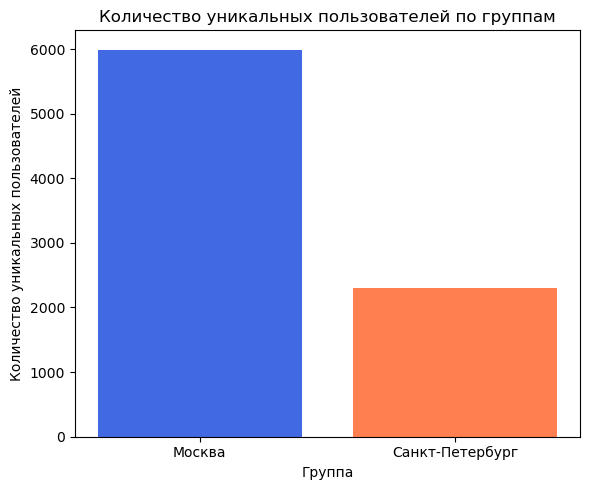

In [11]:
# Создаём контейнер для графика и задаём размер области вывода
plt.figure(figsize=(6, 5))

# Строим стобчатую диаграмму
plt.bar(unique_users_per_city['city'], unique_users_per_city['unique_users'], color=['royalblue', 'coral'])

# Настраиваем оформление графика
plt.title('Количество уникальных пользователей по группам')
plt.xlabel('Группа')
plt.ylabel('Количество уникальных пользователей')
plt.grid(False)

# Выводим график
plt.tight_layout()
plt.show()

В исследовании рассматриваются две группы пользователей: из Москвы (5 990 уникальных пользователей) и из Санкт-Петербурга (2 306 уникальных пользователей). Размеры выборок различаются — московская группа почти в 2,6 раза больше. Эта разница не препятствует проведению статистического анализа, однако для корректного сравнения средних значений следует учитывать возможность неравенства дисперсий.

 - Оценим ститистические показатели столбца `hours` по каждой группе (городу), используя метод describe():

In [12]:
# Разделяем данные по группам
yandex_knigi_no_dupes_msk = yandex_knigi_no_dupes[yandex_knigi_no_dupes['city'] == 'Москва']
yandex_knigi_no_dupes_sbp = yandex_knigi_no_dupes[yandex_knigi_no_dupes['city'] == 'Санкт-Петербург']

In [13]:
# Изучаем статистические показатели в группе Москва
yandex_knigi_no_dupes_msk['hours'].describe()

count    5990.000000
mean       10.848192
std        36.925622
min         0.000022
25%         0.057042
50%         0.888232
75%         5.933439
max       857.209373
Name: hours, dtype: float64

In [14]:
# Изучаем статистические показатели в группе Санкт-Петербург
yandex_knigi_no_dupes_sbp['hours'].describe()

count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64

Построим диаграмму размаха распределения времени активности (hours) по двум группам без отображения выбросов.

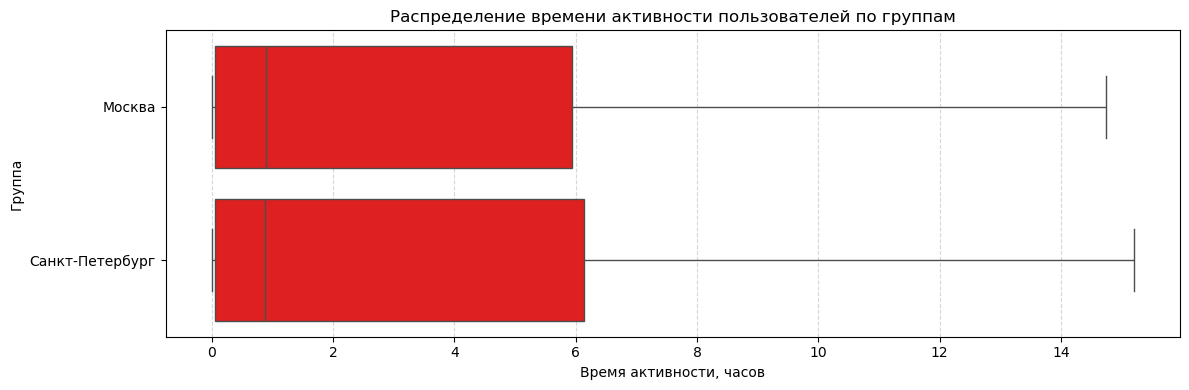

In [15]:
# Создаём контейнер для графика и задаём размер области вывода
plt.figure(figsize=(12, 4))

# Строим boxplot времени активности по городам
sns.boxplot(
    data=yandex_knigi_no_dupes,
    x='hours',
    y='city',
    showfliers=False,
    orient='h',
    color='red')

# Настраиваем оформление графика
plt.title('Распределение времени активности пользователей по группам')
plt.xlabel('Время активности, часов')
plt.ylabel('Группа')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Выводим график
plt.tight_layout()
plt.show()

**Результаты:**

1. Размер выборок и средние значения
 - Москва: 5 990 пользователей, среднее 10.85 часов
 - Санкт-Петербург: 2 306 пользователей, среднее 11.26 часов
 - Среднее время активности в двух группах почти одинаковое.
 - Петербургская выборка меньше, но разница в среднем небольшая (около 0.41 часа).

2. Разброс значений (стандартное отклонение и квартили)
 - Москва: std ≈ 36.93, 25% = 0.057, медиана = 0.888, 75% = 5.933
 - Санкт-Петербург: std ≈ 39.83, 25% = 0.060, медиана = 0.875, 75% = 6.138
 - В обеих группах есть сильная асимметрия и выбросы: медиана (0.88) сильно меньше среднего (11), что говорит о длинном правом хвосте.
 - 75-й перцентиль (5–6 часов) намного меньше среднего, значит несколько пользователей с очень высокой активностью тянут среднее вверх.

3. Минимумы и максимумы
 - Москва: min ≈ 0, max ≈ 857
 - Санкт-Петербург: min ≈ 0, max ≈ 979
 - В обеих группах есть практически нулевые значения активности, а также отдельные экстремально высокие значения (выбросы).
 - Такие выбросы могут сильно влиять на среднее, поэтому при сравнении медиан различия почти отсутствуют.

4. Квартили
 - 25-й и 50-й перцентили почти одинаковы в обеих группах.
 - 75-й перцентиль чуть выше в Санкт-Петербурге, но разница небольшая (около 0.2 часа).
 - Большинство пользователей проводят менее 6 часов активности в день.

**Выводы:**

 - Среднее время активности пользователей в Санкт-Петербурге немного выше, чем в Москве, но разница незначительная.
 - Практически одинаковое распределение активности в двух городах.
 - Данные сильно скошены вправо, среднее завышено выбросами. Медиана и квартильные значения показывают, что типичный пользователь обеих групп проводит менее 1 часа в день.
 - Для статистической проверки гипотезы по имеющимся данным лучше использовать t-тест для независимых выборок с неравными дисперсиями (t-тест Уэлча) и дополнительно рассмотреть непараметрический тест Манна–Уитни из-за наличия выбросов.

Изначальное условие: предполгается, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. 

Определим целевую метрику и сформулируем нулевую и альтернативную гипотезы.

 - Целевая метрика: среднее время активности пользователя. Эта метрика отражает сколько времени пользователь провёл за чтением или прослушиванием книг в приложении.

 - Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br>
 
Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

 - Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br>
   
Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

 - Тип гипотезы: Односторонняя
 - Уровень значимости равен 0.05.

In [16]:
alpha = 0.05

Используя t-тест Уэлча, проверим эту гипотезу. 

T-тест Уэлча является более устойчивым к различиям в дисперсиях по сравнению с классическим t-тестом, однако он остаётся чувствительным к сильным выбросам, особенно при скошенном распределении данных.

Выбросы способны исказить среднее значение и увеличить стандартное отклонение, что может привести к ложным результатам проверки гипотезы — как к появлению мнимой значимости, так и к сглаживанию реальных различий.

Чтобы снизить влияние выбросов, в анализе применем верхний перцентиль 99% в качестве порога отсечения экстремальных значений.

In [17]:
# Находим 99-й перцентиль для каждой группы
q99_msk = yandex_knigi_no_dupes_msk['hours'].quantile(0.99)
q99_sbp = yandex_knigi_no_dupes_sbp['hours'].quantile(0.99)

In [18]:
# Обрезаем экстремальные значения выше 99-го перцентиля
hours_msk_filtered = yandex_knigi_no_dupes_msk[yandex_knigi_no_dupes_msk['hours'] <= q99_msk]['hours']
hours_sbp_filtered = yandex_knigi_no_dupes_sbp[yandex_knigi_no_dupes_sbp['hours'] <= q99_sbp]['hours']

In [19]:
# Применяем t-тест для независимых выборок
stat_welsh_ttest, p_value_welsh_ttest = ttest_ind(hours_sbp_filtered, hours_msk_filtered, equal_var=False, alternative='greater')

print(f"p-value: {p_value_welsh_ttest:.4f}")

p-value: 0.3655


In [20]:
# Интерпретация результата
if p_value_welsh_ttest > alpha:
    print("Недостаточно доказательств для отклонения нулевой гипотезы.")
else:
    print("Отвергаем нулевую гипотезу: среднее время активности пользователей в Санкт-Петербурге больше, чем в Москве.")

Недостаточно доказательств для отклонения нулевой гипотезы.


Теперь используем тест Манна - Уитни для дополнительной проверки той же гипотезы.

In [21]:
# Разделим данные по часам активности для каждой группы
hours_msk = yandex_knigi_no_dupes_msk['hours']
hours_sbp = yandex_knigi_no_dupes_sbp['hours']

In [22]:
# Применяем тест Манна - Уитни
u_stat, p_value_mw_test = mannwhitneyu(hours_sbp, hours_msk, alternative='greater')

print(f"Статистика U: {u_stat:.2f}, p-value: {p_value_mw_test:.5f}")

Статистика U: 6917954.50, p-value: 0.45323


In [23]:
# Интерпретация результата
if p_value_mw_test > alpha:
    print("Недостаточно доказательств для отклонения нулевой гипотезы.")
else:
    print("Отвергаем нулевую гипотезу: среднее время активности пользователей в Санкт-Петербурге больше, чем в Москве.")

Недостаточно доказательств для отклонения нулевой гипотезы.


Результаты t-теста Уэлча и теста Манна–Уитни показали, что средняя активность пользователей в группах Москвы и Санкт-Петербурга не отличается статистически значимо.

<a class = "anchor" id = "3-summary" ><a/>
### Аналитическая записка

**1. Характеристики эксперимента**

`Цель анализа`:
Проверить гипотезу о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.

`Целевая метрика`:
Среднее время активности пользователя (в часах).

Общее количество пользователей:
 - Москва — 5 990 уникальных пользователей
 - Санкт-Петербург — 2 306 уникальных пользователей

Размеры выборок различаются примерно в 2,6 раза, однако этого достаточно для проведения статистических тестов. Распределения метрики в обеих группах имеют значительный разброс и длинные правые хвосты, что отражает наличие очень активных пользователей.

**2. Сравнение ключевой метрики**

 - Среднее время активности пользователей из Москвы: 10.85 часов
 - Среднее время активности пользователей из Санкт-Петербурга: 11.26 часов

Средняя активность пользователей из Санкт-Петербурга немного выше, но разница небольшая (0.4 часа).

**3. Проверка статистической значимости**

Для проверки гипотез применялись:
 - t-тест для независимых выборок с неравными дисперсиями (t-тест Уэлча) — p-value = 0.3655
 - тест Манна-Уитни — p-value = 0.4532

Во всех случаях p-value > 0.05 при уровне значимости α = 0.05.

**4. Выводы и интерпретация**

Различия в среднем времени активности пользователей не являются статистически значимыми.
Нулевая гипотеза не отвергается — нет убедительных доказательств, что пользователи из Санкт-Петербурга проводят больше времени в приложении, чем пользователи из Москвы.

**5. Возможные причины результатов**

 - Пользовательское поведение схоже в обеих столицах: контент, интерфейс и доступ к приложению одинаковы.
 - Возможна влияние внешних факторов, не учтённых в модели (например, погодные условия, сезонность или различия в возрастном составе аудитории).

----